In [1]:
#preparation
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection

digits = load_digits()
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

indeces = [i for i, x in enumerate(target) if x == 3 or x == 9]
filtered_data = data[indeces]
filtered_images = images[indeces]
filtered_target = target[indeces]

X_train, X_test, y_train, y_test = model_selection.train_test_split(filtered_data, filtered_target, test_size = 0.4, random_state = 0)

def features2d(x):
        features = []
        for i in range(len(x)):
            feature_of_3_i = x[i][20] + x[i][28] + 2*x[i][58]# some function of pixels
            feature_of_9_i = x[i][26] + x[i][18] + x[i][37]

            features.append([feature_of_3_i, feature_of_9_i])
        return features
    
print(len(features2d(X_train)))  
print(len(features2d(X_train)[0]))    

217
2


In [2]:
# filter dead pixels

#filtered_data = np.array(X_train)
dead_pixels = []
for i in range(len(filtered_data[0])):
    if(np.var(filtered_data[:,i]) < 0.05):
        dead_pixels.append(i)
        
print((dead_pixels))        

def remove_dead_pixels(X):
    X_filtered = np.array(X)

    for index in reversed(dead_pixels):   
        X_filtered = np.delete(X_filtered, index, 1)
        
    return X_filtered    

len(remove_dead_pixels(X_train)[0])

[0, 8, 16, 24, 31, 32, 39, 40, 47, 48, 56]


53

In [3]:
def fit_lda(training_features, training_labels):
    N = len(training_features)
    D = len(training_features[0])
    
    number_of_3 = 0
    number_of_9 = 0
    mu_of_3 = np.zeros(D)
    mu_of_9 = np.zeros(D)
    
    for i in range(N):
        if(training_labels[i] == 3):
            number_of_3 += 1
            mu_of_3 += np.array(training_features[i])
        if(training_labels[i] == 9):
            number_of_9 += 1
            mu_of_9 += np.array(training_features[i])
            
    mu_of_3 /= number_of_3
    mu_of_9 /= number_of_9
    
    mu = [mu_of_3, mu_of_9]
    
    sigma = np.array([np.zeros(D) for i in range(D)])

    for i in range(N):
        if(training_labels[i] == 3):
            sigma += np.outer(training_features[i] - mu_of_3, training_features[i] - mu_of_3)
        if(training_labels[i] == 9):
            sigma += np.outer(training_features[i] - mu_of_9, training_features[i] - mu_of_9)
            
    sigma /= N        
            
    p_3 = number_of_3 / N 
    p_9 = number_of_9 / N
    p = [p_3, p_9]
            
    return mu, sigma, p

#training_features = features2d(X_train)
#training_labels = y_train
#
#mu, covmat, p = fit_lda(training_features, training_labels)

In [4]:
def predict_lda(mu, covmat, p, test_features):
    test_features = np.array(test_features)
    
    beta = np.linalg.inv(covmat).dot(mu[1] - mu[0]) 
    b = -0.5 * (mu[1] + mu[0]).dot(beta) + np.log(p[0] / p[1])
    
    predicted_labels = []
    for i in range(len(test_features)):
        predicted_labels.append(np.sign(test_features[i].dot(beta) + b))
        
    return predicted_labels

def calculate_error(predicted_labels, real_labels):
    if(not len(predicted_labels) == len(real_labels)):
        print("falsche Länge")
        return
    
    number_errors = 0
    for i in range(len(predicted_labels)):     
        real_label_modified = -1 if real_labels[i] == 3 else 1
        
        if(not predicted_labels[i] == real_label_modified):
            number_errors += 1
         
    return number_errors / len(predicted_labels)

error of test set: 0.0958904109589041
error of training set: 0.11981566820276497


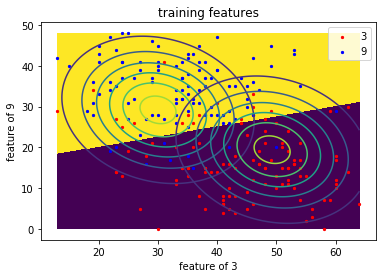

[103.51116919  58.58316613]
[[ 0.9523869   0.30489211]
 [-0.30489211  0.9523869 ]]


In [68]:
#with the feature function from 1.2
training_labels = y_train
mu, covmat, p = fit_lda(features2d(X_train), training_labels)
#print(len(covmat[0]))

predicted_labels = predict_lda(mu, covmat, p, features2d(X_test))
print("error of test set: " + str(calculate_error(predicted_labels, y_test)))

predicted_labels = predict_lda(mu, covmat, p, features2d(X_train))
print("error of training set: " + str(calculate_error(predicted_labels, y_train)))


beta = np.linalg.inv(covmat).dot(mu[1] - mu[0]) 
b = -0.5 * (mu[1] + mu[0]).dot(beta) + np.log(p[0] / p[1])

training_features = np.array(features2d(X_train))
x = np.linspace(min(training_features[:,0]), max(training_features[:,0]), 400)
y = np.linspace(min(training_features[:,1]), max(training_features[:,1]), 400)

def contour(x, y, mu):
    return 1 / np.sqrt(2*np.pi*np.linalg.det(covmat)) * np.exp(-0.5 * (np.array([x - mu[0], y - mu[1]]).dot(np.linalg.inv(covmat)).dot(np.array([x - mu[0], y - mu[1]]))))

z_contour_3 = np.array([np.zeros(len(x)) for i in range(len(y))])
z_contour_9 = np.array([np.zeros(len(x)) for i in range(len(y))])

for i in range(len(x)):
    for j in range(len(y)):
        z_contour_3[i][j] = contour(x[i], y[j], mu[0])
        z_contour_9[i][j] = contour(x[i], y[j], mu[1])

plt.contour(x, y, z_contour_3)
plt.contour(x, y, z_contour_9)

x, y = np.meshgrid(x, y)
z = np.sign(x * beta[0] + y * beta[1] + b)
plt.pcolormesh(x, y, z)
plt.scatter(training_features[y_train == 3, 0], training_features[y_train == 3, 1], color = "red", label = "3", s = 5)
plt.scatter(training_features[y_train == 9, 0], training_features[y_train == 9, 1], color = "blue", label = "9", s = 5)
plt.title("training features")
plt.xlabel("feature of 3")
plt.ylabel("feature of 9")
plt.legend()
plt.show()

eigenvalues, eigenvectors = np.linalg.eig(covmat)
print(eigenvalues)
print(eigenvectors)

In [69]:
#with all pixels except dead pixels as features

mu, covmat, p = fit_lda(remove_dead_pixels(X_train), training_labels)
#print(np.linalg.det(covmat))
predicted_labels = predict_lda(mu, covmat, p, remove_dead_pixels(X_test))
print("error of test set: " + str(calculate_error(predicted_labels, y_test)))

predicted_labels = predict_lda(mu, covmat, p, remove_dead_pixels(X_train))
print("error of training set: " + str(calculate_error(predicted_labels, y_train)))

error of test set: 0.0136986301369863
error of training set: 0.004608294930875576
